In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive, files
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/sampah"
folders = ["organik", "anorganik"]


for folder in folders:
    folder_path = os.path.join(BASE_PATH, folder)
    print(f"Jumlah gambar {folder}: {len(os.listdir(folder_path))}")

# Augmentasi citra
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)


Mounted at /content/drive
Jumlah gambar organik: 60
Jumlah gambar anorganik: 42


In [3]:
# 1. Sampling & Quantization
def sampling_quantization(img, size=(200,200)):
    img_resize = cv2.resize(img, size)
    gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    gray_4bit = (gray // 16) * 16
    return img_resize, gray_4bit

# 2. Histogram & Enhancement
def enhancement(gray_img):
    return cv2.equalizeHist(gray_img)

# 3. Filtering / Restoration
def restoration(enhanced_img):
    return cv2.GaussianBlur(enhanced_img, (5,5), 0)

# 4. Segmentasi & Morfologi + Deteksi Tepi
def segmentation(filtered_img):
    _, thresh = cv2.threshold(filtered_img, 120, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)
    edges = cv2.Canny(filtered_img, 100, 200)
    combined = cv2.bitwise_or(morph, edges)
    contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask_clean = np.zeros_like(combined)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask_clean, [cnt], -1, 255, -1)

    return mask_clean, morph, edges

# 5. Ekstraksi fitur
def extract_features(img):
    img_resize, gray_q = sampling_quantization(img)
    enhanced = enhancement(gray_q)
    filtered = restoration(enhanced)
    mask_clean, morph, edges = segmentation(filtered)

    hsv = cv2.cvtColor(img_resize, cv2.COLOR_BGR2HSV)
    h_mean = np.mean(hsv[:,:,0])
    s_mean = np.mean(hsv[:,:,1])
    v_mean = np.mean(hsv[:,:,2])
    area = np.sum(mask_clean > 0)

    return [h_mean, s_mean, v_mean, area], img_resize, gray_q, enhanced, filtered, morph, edges, mask_clean



example_img_path = os.path.join(BASE_PATH, folders[0], os.listdir(os.path.join(BASE_PATH, folders[0]))[0])
img_example = cv2.imread(example_img_path)
features, img_r, gray_q, enhanced, filtered, morph, edges, mask_clean = extract_features(img_example)

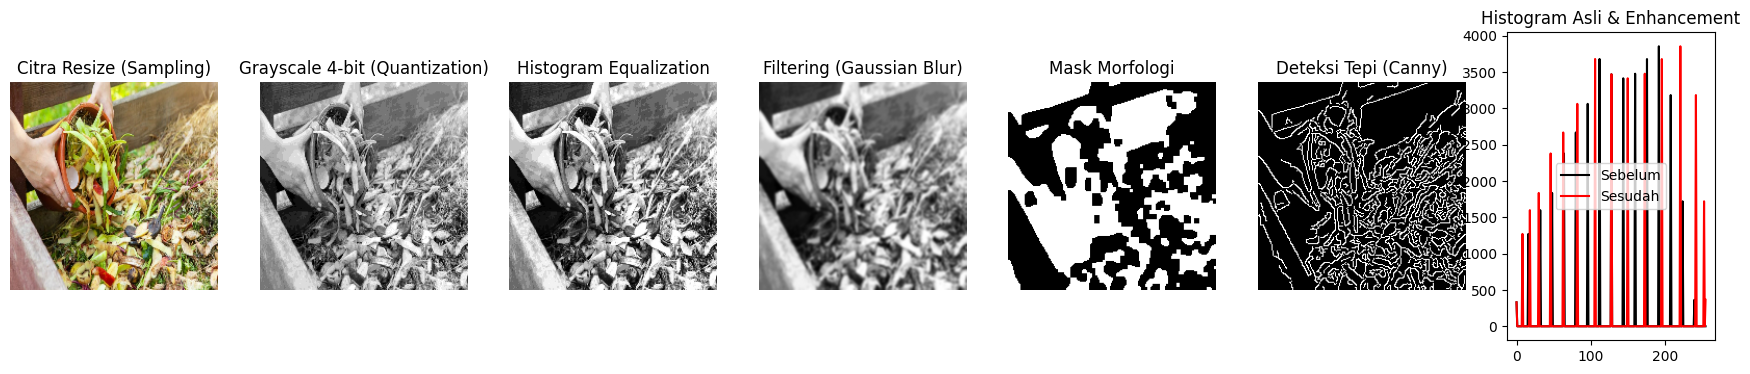

In [4]:
features, img_r, gray_q, enhanced, filtered, morph, edges, mask_clean = extract_features(img_example)

hist_before = cv2.calcHist([gray_q],[0],None,[256],[0,256])
hist_after = cv2.calcHist([enhanced],[0],None,[256],[0,256])

plt.figure(figsize=(22,4))

plt.subplot(1,7,1)
plt.imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))
plt.title("Citra Resize (Sampling)")
plt.axis("off")

plt.subplot(1,7,2)
plt.imshow(gray_q, cmap="gray")
plt.title("Grayscale 4-bit (Quantization)")
plt.axis("off")

plt.subplot(1,7,3)
plt.imshow(enhanced, cmap="gray")
plt.title("Histogram Equalization")
plt.axis("off")

plt.subplot(1,7,4)
plt.imshow(filtered, cmap="gray")
plt.title("Filtering (Gaussian Blur)")
plt.axis("off")

plt.subplot(1,7,5)
plt.imshow(morph, cmap="gray")
plt.title("Mask Morfologi")
plt.axis("off")

plt.subplot(1,7,6)
plt.imshow(edges, cmap="gray")
plt.title("Deteksi Tepi (Canny)")
plt.axis("off")

plt.subplot(1,7,7)
plt.plot(hist_before, color='black', label='Sebelum')
plt.plot(hist_after, color='red', label='Sesudah')
plt.title("Histogram Asli & Enhancement")
plt.legend()

plt.show()


In [6]:
X = []
y = []

for idx, folder in enumerate(folders):
    folder_path = os.path.join(BASE_PATH, folder)
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        features, _, _, _, _, _, _, _ = extract_features(img)
        X.append(features)
        y.append(idx)
        img_array = np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0)
        aug_iter = datagen.flow(img_array, batch_size=1)
        for i in range(2):
            aug_img = next(aug_iter)[0].astype(np.uint8)
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            features_aug, _, _, _, _, _, _, _ = extract_features(aug_img)
            X.append(features_aug)
            y.append(idx)

print("Jumlah data setelah augmentasi:", len(X))

Jumlah data setelah augmentasi: 306


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

y_pred = clf.predict(X_test)
print("Akurasi model:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

joblib.dump(clf, "/content/sampah_classifier.pkl")


Cross-validation scores: [0.81632653 0.75510204 0.81632653 0.79591837 0.85416667]
Mean CV score: 0.8075680272108844
Akurasi model: 0.9193548387096774
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        36
           1       0.89      0.92      0.91        26

    accuracy                           0.92        62
   macro avg       0.92      0.92      0.92        62
weighted avg       0.92      0.92      0.92        62

Confusion Matrix:
 [[33  3]
 [ 2 24]]


['/content/sampah_classifier.pkl']

In [10]:
def detect_new_image(model, img_path):
    img = cv2.imread(img_path)

    features, img_r, gray_q, enhanced, filtered, morph, edges, mask_clean = extract_features(img)
    label_num = model.predict([features])[0]
    label_text = "Sampah Organik" if label_num==0 else "Sampah Anorganik"

    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = img_r.copy()
    for cnt in contours:
        if cv2.contourArea(cnt) > 1000:
            x,y,w,h = cv2.boundingRect(cnt)
            color = (0,255,0) if label_num==0 else (0,0,255)
            cv2.rectangle(output, (x,y), (x+w,y+h), color, 2)
            cv2.putText(output, label_text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return output, label_text, gray_q, enhanced, morph, edges, mask_clean

Saving WhatsApp Image 2026-01-11 at 9.50.30 AM.jpeg to WhatsApp Image 2026-01-11 at 9.50.30 AM (2).jpeg
Hasil Deteksi: Sampah Organik


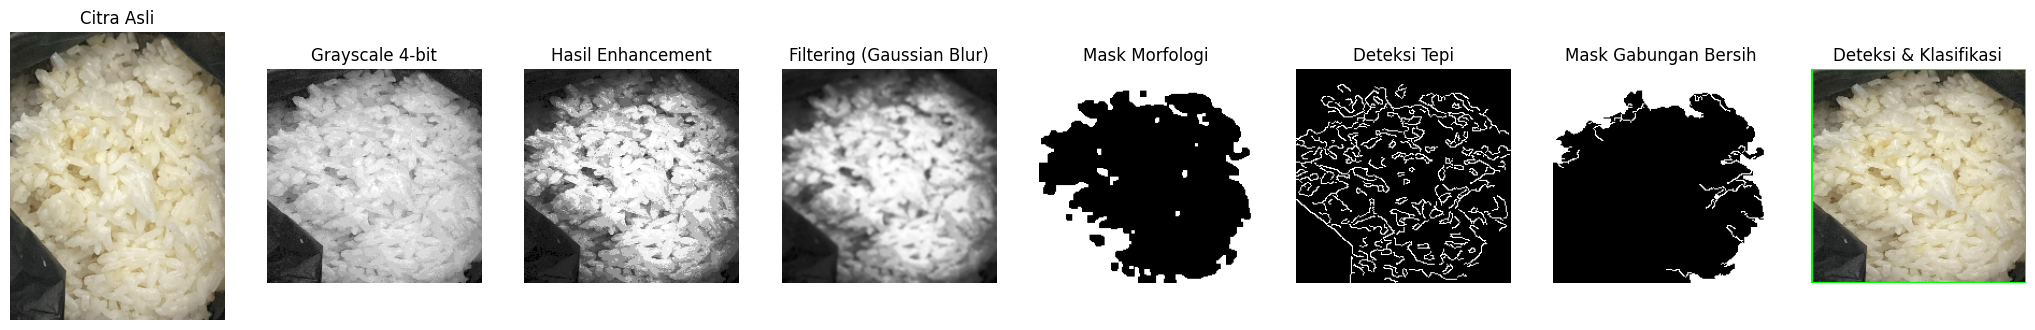

In [17]:
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

clf_loaded = joblib.load("/content/sampah_classifier.pkl")
result, label, gray_q, enhanced, morph, edges, mask_clean = detect_new_image(clf_loaded, img_path)

print("Hasil Deteksi:", label)


filtered_vis = cv2.GaussianBlur(enhanced, (5,5), 0)

plt.figure(figsize=(26,5))

plt.subplot(1,8,1)
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title("Citra Asli")
plt.axis("off")

plt.subplot(1,8,2)
plt.imshow(gray_q, cmap="gray")
plt.title("Grayscale 4-bit")
plt.axis("off")

plt.subplot(1,8,3)
plt.imshow(enhanced, cmap="gray")
plt.title("Hasil Enhancement")
plt.axis("off")

plt.subplot(1,8,4)
plt.imshow(filtered_vis, cmap="gray")
plt.title("Filtering (Gaussian Blur)")
plt.axis("off")

plt.subplot(1,8,5)
plt.imshow(morph, cmap="gray")
plt.title("Mask Morfologi")
plt.axis("off")

plt.subplot(1,8,6)
plt.imshow(edges, cmap="gray")
plt.title("Deteksi Tepi")
plt.axis("off")

plt.subplot(1,8,7)
plt.imshow(mask_clean, cmap="gray")
plt.title("Mask Gabungan Bersih")
plt.axis("off")

plt.subplot(1,8,8)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Deteksi & Klasifikasi")
plt.axis("off")

plt.show()


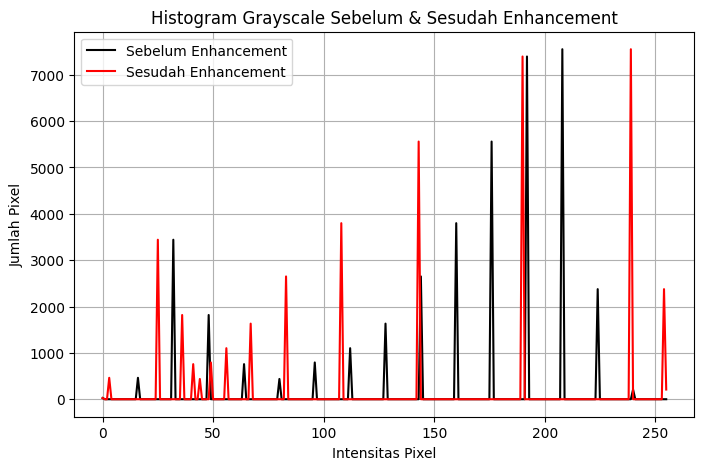

In [18]:
hist_before = cv2.calcHist([gray_q], [0], None, [256], [0,256])
hist_after = cv2.calcHist([enhanced], [0], None, [256], [0,256])

plt.figure(figsize=(8,5))
plt.plot(hist_before, color='black', label='Sebelum Enhancement')
plt.plot(hist_after, color='red', label='Sesudah Enhancement')
plt.title("Histogram Grayscale Sebelum & Sesudah Enhancement")
plt.xlabel("Intensitas Pixel")
plt.ylabel("Jumlah Pixel")
plt.legend()
plt.grid(True)
plt.show()
